# Youtube Agent using LangGraph and Qubrid AI

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QubridAI-Inc/qubrid-cookbook/blob/main/Notebooks/Langgraph_Youtube_Agent.ipynb)

![Qubrid x Langgraph](../../qubrid-cookbook/Assets/Images/Langgraph_x_Qubrid.png)

This notebook shows how to build parallel agent workflows with LangGraph to turn YouTube videos into structured intelligence reports.

- **Whisper Large V3** transcribes audio, and **GPT-OSS-120b** generates summaries and insights, both hosted on the **Qubrid AI Platform** for low-latency inference.

- A fan-out/fan-in architecture enables concurrent execution and reliable shared state across parallel nodes.

**Pattern:**
```
URL → Transcribe → [Parallel: Chapters & Summary] → PDF Synthesis



### The Pattern You'll Master

<img
  src="https://drive.google.com/uc?export=view&id=1CdU8-9t5E1KsJ0Lpth_QcJxtNPEeThPg"
  alt="Parallel Workflow Pattern"
  width="500"
/>

Let's begin! 🚀

## 1. Environment Setup
Set up the development environment by initializing the orchestration stack and authenticating with Qubrid AI.

- Core Orchestration: LangGraph & LangChain for stateful agent workflows.

- Media & PDF Tools: yt-dlp for audio extraction, fpdf2 for report generation.

- Qubrid AI Integration: Configure QUBRID_API_KEY to access hosted Whisper Large V3 and GPT-OSS-120b.

- Environment Agnostic: Auto-detects Local or Google Colab for seamless execution.

In [1]:
!uv pip install -U langgraph langchain_core yt-dlp fpdf2 requests python-dotenv

Using Python 3.12.12 environment at: /usr
Resolved 37 packages in 403ms
Prepared 11 packages in 436ms
Uninstalled 9 packages in 31ms
Installed 11 packages in 42ms
 + fpdf2==2.8.5
 - langchain-core==1.2.7
 + langchain-core==1.2.8
 - langsmith==0.6.6
 + langsmith==0.6.8
 - orjson==3.11.5
 + orjson==3.11.7
 - packaging==25.0
 + packaging==26.0
 - pillow==11.3.0
 + pillow==12.1.0
 - pydantic==2.12.3
 + pydantic==2.12.5
 - pydantic-core==2.41.4
 + pydantic-core==2.41.5
 - requests==2.32.4
 + requests==2.32.5
 - urllib3==2.5.0
 + urllib3==2.6.3
 + yt-dlp==2026.1.31


In [2]:
#Import required libraries
import os
import re
import requests
import json
import time, random
from typing import List, Optional, Any, TypedDict, Iterator
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, AIMessageChunk
from langchain_core.outputs import ChatResult, ChatGeneration, ChatGenerationChunk
from pydantic import Field
from langgraph.graph import StateGraph, END
import yt_dlp
from fpdf import FPDF

## Load QUBRID_API_KEY by automatically detecting and handling Colab vs local environments
try:
    # Standard for Google Colab
    from google.colab import userdata
    QUBRID_API_KEY = userdata.get('QUBRID_API_KEY')
    print("Environment: Google Colab detected.")
except ImportError:
    # Standard for local development
    from dotenv import load_dotenv
    load_dotenv()
    QUBRID_API_KEY = os.getenv("QUBRID_API_KEY")
    print("Environment: Local environment detected.")

if not QUBRID_API_KEY:
    raise ValueError("QUBRID_API_KEY missing. Please set it in your environment.")

Environment: Google Colab detected.


## 2. Setting up the LLM Client
We implement a custom LangChain wrapper for the **gpt-oss-120b** model on Qubrid.

In [3]:
# Custom LangChain-compatible chat model wrapper for Qubrid AI with streaming and non-streaming support
class ChatQubrid(BaseChatModel):
    """Modular Custom Chat Model for Qubrid AI supporting Streaming."""
    api_key: str = Field(..., description="Your Qubrid API Key")
    base_url: str = "https://platform.qubrid.com/api/v1/qubridai/chat/completions"
    model_name: str = "openai/gpt-oss-120b"
    temperature: float = 0.3
    max_tokens: int = 1500

    @property
    def _llm_type(self) -> str:
        return "qubrid-chat-model"

# Centralized request construction to keep streaming and non-streaming logic consistent
    def _prepare_payload(self, messages: List[BaseMessage], stream: bool = False) -> tuple:
        """Shared logic to build headers and JSON payload."""
        headers = {
            "Authorization": f"Bearer {self.api_key}",
            "Content-Type": "application/json"
        }
        payload = {
            "model": self.model_name,
            "messages": [{"role": "user", "content": m.content} for m in messages],
            "temperature": self.temperature,
            "max_tokens": self.max_tokens,
            "stream": stream
        }
        return headers, payload

# Execute standard (non-streaming) chat completion request
    def _generate(self, messages: List[BaseMessage], stop: Optional[List[str]] = None, **kwargs: Any) -> ChatResult:
        """Handles non-streaming requests with status validation."""
        headers, payload = self._prepare_payload(messages, stream=False)

        res = requests.post(self.base_url, headers=headers, json=payload, timeout=60)

        if res.status_code != 200:
            error_msg = f"[Qubrid Error] API returned {res.status_code}. Response: {res.text[:500]}"
            print(error_msg)
            raise ValueError(error_msg)

        try:
            data = res.json()
            # Support both Qubrid direct content and OpenAI-compatible choice structures
            content = data.get("content") or data.get("choices", [{}])[0].get("message", {}).get("content")
            return ChatResult(generations=[ChatGeneration(message=AIMessage(content=str(content)))])
        except Exception as e:
            raise ValueError(f"Failed to process response: {str(e)}. Raw text: {res.text[:500]}")

# Parse Server-Sent Events (SSE) stream and yield tokens incrementally
    def _stream(self, messages: List[BaseMessage], stop: Optional[List[str]] = None, **kwargs: Any) -> Iterator[ChatGenerationChunk]:
        """Handles streaming responses using Server-Sent Events (SSE)."""
        headers, payload = self._prepare_payload(messages, stream=True)

        res = requests.post(self.base_url, headers=headers, json=payload, timeout=60, stream=True)
        res.raise_for_status()

        for line in res.iter_lines():
            if not line: continue
            decoded_line = line.decode('utf-8')
            if decoded_line.startswith("data: "):
                data_str = decoded_line[len("data: "):]
                if data_str.strip() == "[DONE]": break
                try:
                    data = json.loads(data_str)
                    delta = data.get("choices", [{}])[0].get("delta", {}).get("content", "")
                    if delta:
                        yield ChatGenerationChunk(message=AIMessageChunk(content=delta))
                except json.JSONDecodeError:
                    continue

llm = ChatQubrid(api_key=QUBRID_API_KEY)

## 3. Utility Functions
 Utility helpers for audio extraction, PDF-safe text normalization, and structured JSON parsing





In [4]:
# Utility: Download and extract high-quality audio from a YouTube video
def extract_audio_from_youtube(url: str) -> str:
    """
    Standalone utility function for audio extraction.
    Optimized for headless environments (like Colab) using the 'android' player client
    to bypass signature/sign-in requirements.
    """
    print(f"[Tool] Extracting audio from YouTube: {url}")
    output_base = "audio"
    output_file = f"{output_base}.m4a"

    if os.path.exists(output_file):
        os.remove(output_file)

    ydl_opts = {
        "format": "bestaudio/best",
        "outtmpl": f"{output_base}.%(ext)s",
        "quiet": True,
        "no_warnings": True,
        "nocheckcertificate": True,
        "user_agent": "Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Mobile Safari/537.36",
        "referer": "https://www.youtube.com/",
        "extractor_args": {
            "youtube": {
                "player_client": ["android"],
                "skip": ["hls", "dash"],
            }
        },
        "postprocessors": [{
            "key": "FFmpegExtractAudio",
            "preferredcodec": "m4a",
        }],
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])

    return output_file

In [5]:
# Utility: Normalize text for PDF-safe Latin-1 encoding
def sanitize_text_for_pdf(text: str) -> str:
    """Converts high-unicode characters to safe Latin-1 equivalents."""
    if not text: return ""
    mapping = {"\u2013": "-", "\u2014": "--", "\u2018": "'", "\u2019": "'", "\u201c": '"', "\u201d": '"', "\u2022": "*", "\u2026": "..."}
    for char, replacement in mapping.items():
        text = text.replace(char, replacement)
    return text.encode("latin-1", "ignore").decode("latin-1")

In [6]:
# Utility: Extract the first valid JSON block from mixed or noisy text output
def extract_json_from_text(text: str):
    """Extracts the first JSON array/object block from a string, ignoring leading/trailing chatter."""
    try:
        start = text.find('[')
        end = text.rfind(']') + 1
        if start != -1 and end != 0:
            json_str = text[start:end]
            return json.loads(json_str)
        return None
    except Exception as e:
        print(f"[Log] Regex Extraction Failed: {e}")
        return None

Utility functions for synthesizer_node:

In [7]:
# Initializes a PDF document with a title, ready for adding report content.
from fpdf import FPDF
def initialize_pdf(title: str = "Video Intelligence Report") -> FPDF:
    """
    Initializes a PDF document and renders the report title.
    """
    pdf = FPDF()
    pdf.add_page()

    pdf.set_font("Helvetica", "B", 26)
    pdf.cell(0, 25, title, new_x="LMARGIN", new_y="NEXT", align="C")
    pdf.ln(8)

    return pdf

# Renders the video timeline section in the PDF using timestamped chapter data.
def render_timeline_section(pdf: FPDF, timestamps: str):
    """
    Renders the video timeline (timestamped chapters) section.
    Accepts raw or JSON-formatted timestamp data.
    """
    pdf.set_font("Helvetica", "B", 18)
    pdf.set_text_color(0, 102, 204)
    pdf.cell(0, 15, "Video Timeline", new_x="LMARGIN", new_y="NEXT")

    chapters = extract_json_from_text(timestamps)

    if chapters and isinstance(chapters, list):
        pdf.set_font("Helvetica", "", 11)
        pdf.set_text_color(0, 0, 0)

        with pdf.table(col_widths=(30, 160), borders_layout="SINGLE_TOP_LINE") as table:
            header = table.row()
            header.cell("TIME")
            header.cell("TOPIC")

            for item in chapters:
                row = table.row()
                row.cell(sanitize_text_for_pdf(str(item.get("time", ""))))
                row.cell(sanitize_text_for_pdf(str(item.get("topic", ""))))
    else:
        pdf.set_font("Helvetica", "I", 10)
        pdf.set_text_color(80, 80, 80)
        pdf.multi_cell(0, 7, sanitize_text_for_pdf(timestamps))

    pdf.ln(10)

# Renders the executive summary section in the PDF from structured or raw summary text.
def render_summary_section(pdf: FPDF, summary: str):
    """
    Renders the executive summary section from structured or raw text.
    """
    pdf.set_font("Helvetica", "B", 18)
    pdf.set_text_color(0, 102, 204)
    pdf.cell(0, 15, "Executive Summary", new_x="LMARGIN", new_y="NEXT")

    summary_data = extract_json_from_text(summary)

    if summary_data and isinstance(summary_data, list):
        for point in summary_data:
            pdf.set_font("Helvetica", "B", 12)
            pdf.set_text_color(40, 40, 40)
            pdf.multi_cell(
                0, 8,
                sanitize_text_for_pdf(f"- {point.get('point', '')}")
            )

            pdf.set_font("Helvetica", "", 11)
            pdf.set_text_color(80, 80, 80)

            for detail in point.get("details", []):
                pdf.set_x(20)
                pdf.multi_cell(
                    0, 7,
                    sanitize_text_for_pdf(f"* {detail}")
                )
            pdf.ln(2)
    else:
        pdf.set_font("Helvetica", "I", 10)
        pdf.set_text_color(80, 80, 80)
        pdf.multi_cell(0, 7, sanitize_text_for_pdf(summary))

    pdf.ln(5)

# Saves the PDF to disk and returns the file path of the generated report.
def export_pdf(pdf: FPDF, output_path: str = "final_report.pdf") -> str:
    """
    Saves the PDF to disk and returns the output path.
    """
    pdf.output(output_path)
    return output_path

Utility functions for transcriber node, chapter node and summary node:

In [8]:
# Utility function for the transcriber_node to handle Whisper API logic
def transcribe_audio_qubrid(audio_path: str) -> str:
    """
    Independent tool to send audio to Qubrid Whisper Large V3 for transcription.
    """
    headers = {"Authorization": f"Bearer {QUBRID_API_KEY}"}
    with open(audio_path, "rb") as f:
        res = requests.post(
            "https://platform.qubrid.com/api/v1/qubridai/audio/transcribe",
            headers=headers,
            files={"file": f},
            data={"model": "openai/whisper-large-v3"}
        )
    return res.json().get("text", "Transcription failed.")

# Utility function for the chapters_node to handle LLM chapter extraction
def generate_chapters_from_transcript(transcript: str) -> str:
    """
    Independent tool to analyze transcript and generate timestamped chapters using LLM.
    """
    prompt = f"Extract chapters from transcript. Return ONLY a JSON list: [{{'time': '00:00', 'topic': 'Intro'}}]. Transcript: {transcript}"
    res = llm.invoke([HumanMessage(content=prompt)])
    return res.content

# Utility function for the summary_node to handle LLM content summarization
def generate_summary_from_transcript(transcript: str) -> str:
    """
    Independent tool to summarize transcript into key points using LLM.
    """
    prompt = f"Summarize transcript into key points. Return ONLY a JSON list: [{{'point': 'Title', 'details': ['Sub-bullet']}}]. Transcript: {transcript}"
    res = llm.invoke([HumanMessage(content=prompt)])
    return res.content

## 4. Agent Orchestration (LangGraph)
Agent workflow for transforming YouTube videos into structured insights and a downloadable PDF report

In [9]:
# Shared state schema passed between agent nodes during the workflow execution
class AgentState(TypedDict):
    url: str
    transcript: str
    timestamps: str
    summary: str
    pdf_path: str

# Agent node responsible for extracting audio and converting speech to text using Whisper
def transcriber_node(state: AgentState):
    print("\n--- [Node: Speech-to-Text] ---")
    # Download and extract audio from the provided YouTube URL
    audio_path = extract_audio_from_youtube(state['url'])
    file_size = os.path.getsize(audio_path) / (1024 * 1024)
    print(f"  [+] Audio Extracted: {audio_path} ({file_size:.2f} MB)")

    print("  [>] Requesting Qubrid Whisper Large v3 Logic...")
    # Delegate API call to utility function
    transcript = transcribe_audio_qubrid(audio_path)

    print(f"  [✓] Transcription Completed ({len(transcript):,} characters)")
    print(f"  [!] Preview: \"{transcript[:150]}...\"")
    return {"transcript": transcript}

# Agent node that analyzes the transcript and generates a timestamped chapter timeline
def chapters_node(state: AgentState):
    print("\n--- [Node: Timeline Generation] ---")
    # Delegate LLM logic to utility function
    content = generate_chapters_from_transcript(state['transcript'])

    with open("timestamps.txt", "w") as f: f.write(content)
    # Metadata Logging
    parsed = extract_json_from_text(content)
    count = len(parsed) if parsed else 0
    print(f"  [✓] Analysis complete. {count} chapters detected and saved.")
    return {"timestamps": content}

# Agent node that summarizes the transcript into structured key points
def summary_node(state: AgentState):
    print("\n--- [Node: Content Summarization] ---")
    # Delegate LLM logic to utility function
    content = generate_summary_from_transcript(state['transcript'])

    with open("summary.txt", "w") as f: f.write(content)
    print(f"  [✓] Summary generated ({len(content):,} characters) and saved.")
    return {"summary": content}

# Agent node that synthesizes timeline and summary data into a formatted PDF report
def synthesizer_node(state: AgentState):
    print("\n--- [Node: PDF Synthesis] ---")
    pdf = initialize_pdf()

    print("  [>] Rendering timeline...")
    render_timeline_section(pdf, state["timestamps"])

    print("  [>] Rendering executive summary...")
    render_summary_section(pdf, state["summary"])

    output_path = export_pdf(pdf)

    print(f"  [✓] Report generated: {output_path}")
    return {"pdf_path": output_path}

## 5. Graph Construction
We use the `StateGraph` builder to define the fan-out/fan-in architecture.

In [10]:
# Initialize a LangGraph state machine with a shared agent state
builder = StateGraph(AgentState)

# Register agent nodes representing individual processing stages
builder.add_node("transcribe", transcriber_node)   # Speech-to-text conversion
builder.add_node("chapters", chapters_node)         # Chapter extraction
builder.add_node("summary", summary_node)           # Content summarization
builder.add_node("synthesize", synthesizer_node)    # Final PDF generation

# Define the entry point of the graph (first node to execute)
builder.set_entry_point("transcribe")

builder.add_edge("transcribe", "chapters")
builder.add_edge("transcribe", "summary")

builder.add_edge("chapters", "synthesize")
builder.add_edge("summary", "synthesize")

builder.add_edge("synthesize", END)

app = builder.compile()

## 6. Execution Example
Launch the agent with a YouTube URL. LangGraph will automatically handle the parallel scheduling of the LLM tasks.

In [11]:
inputs = {"url": "https://youtu.be/osxdLudcCoE"}
outputs = app.invoke(inputs)


--- [Node: Speech-to-Text] ---
[Tool] Extracting audio from YouTube: https://youtu.be/osxdLudcCoE
  [+] Audio Extracted: audio.m4a (5.87 MB)
  [>] Requesting Qubrid Whisper Large v3 Logic...
  [✓] Transcription Completed (12,799 characters)
  [!] Preview: "Have you ever wanted to create impressive AI-generated images from just a piece of text, but felt the setup was too daunting or technical? Think again..."

--- [Node: Timeline Generation] ---

--- [Node: Content Summarization] ---
  [✓] Analysis complete. 10 chapters detected and saved.
  [✓] Summary generated (2,365 characters) and saved.

--- [Node: PDF Synthesis] ---
  [>] Rendering timeline...
  [>] Rendering executive summary...
  [✓] Report generated: final_report.pdf


In [18]:
# Download the generated PDF
from google.colab import files
files.download(outputs['pdf_path'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Workflow Visualization

The graph shows how data flows through transcription, parallel content analysis, and final report synthesis.

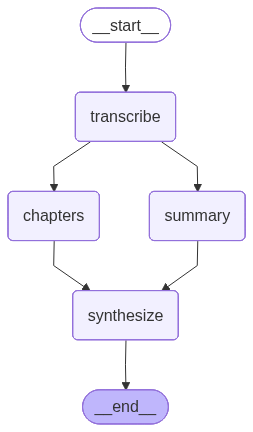

In [12]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

We've built a parallel agent workflow system that goes beyond simple linear chains by:

- Task Parallelism: Running nodes concurrently to save time.
- State Persistence: Maintaining structured data flow across all modular nodes.
- Efficient Orchestration: Separating heavy I/O tasks from core AI reasoning.

## Start Building Intelligent Agents ⚡

[🔑 Get Your API Key](https://platform.qubrid.com/signup) ·
[🤖 Explore Available Models](https://docs.platform.qubrid.com/inferencing/Serverless%20Models) ·
[🏏 Try the Playground](https://platform.qubrid.com/playground)

__Build, deploy, and scale agentic workflows with Qubrid AI.__